# Backtrack Testbed Notebook

Short notebook to test Bryans functions.

In [1]:
# Standard library
import sys

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import metpy 

We want MetPy ver 1.6.1

In [2]:
# !pip install metpy --upgrade

In [3]:
print(f" Harnessing the power of MetPy version {metpy.__version__} ️")

 Harnessing the power of MetPy version 1.6.1 ️


In [4]:
sys.path.insert(1, '../sealsml')

# Azimuth Testing

In [5]:
from geometry import GeoCalculator, polar_to_cartesian

In [6]:
# x, y, and z

ref = np.array([[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]])

target = np.array([[0., 1., 0.], # north, 0
                   [1., 0., 0.],
                   [0., -1., 0.],
                   [-1., 0., 0.]])

In [7]:
geometry_class = GeoCalculator(ref, target)
geometry_class.calculate_azimuth()

Warning, Azimuth Calculation might be wrong for vertically offset points


array([  0.,  90., 180., 270.])

# Random u and v data

In [8]:
# Set the number of examples
num_examples = 100

# Generate random u and v components using a normal distribution with mean 0 and standard deviation 5
u_data = np.random.normal(loc=0, scale=5, size=num_examples)
v_data = np.random.normal(loc=0, scale=5, size=num_examples)

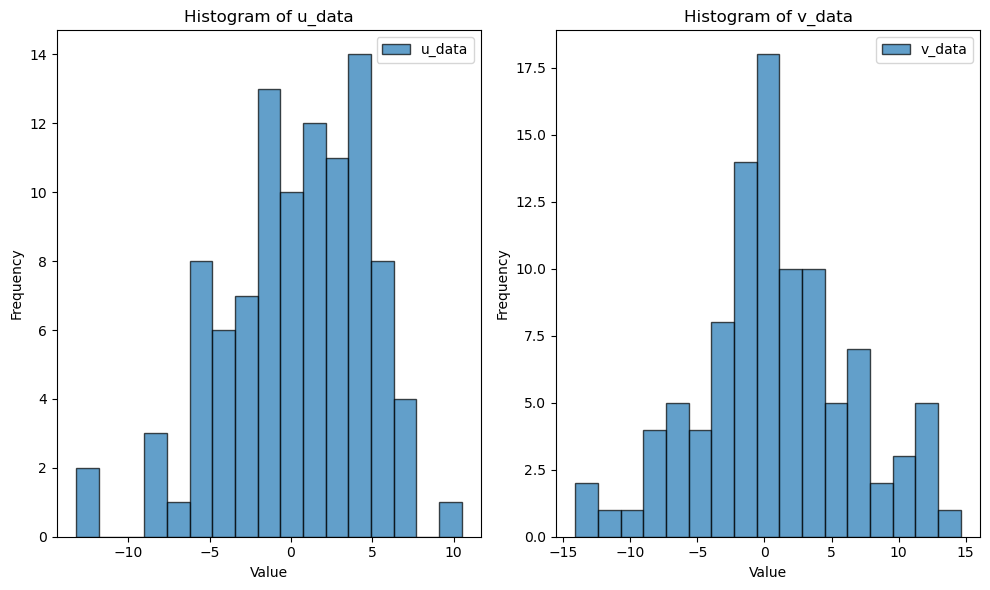

In [9]:
n_bins = 17

# Create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Create the histograms
ax1.hist(u_data, bins=n_bins, edgecolor='black', alpha=0.7, label='u_data')
ax2.hist(v_data, bins=n_bins, edgecolor='black', alpha=0.7, label='v_data')

# Add labels and title
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of u_data')
ax2.set_xlabel('Value')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of v_data')

# Add legend
ax1.legend()
ax2.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Let's show how to use MetPy Calc

In [10]:
from metpy.calc import wind_direction
from metpy.calc import wind_speed

from metpy.units import units

In [11]:
wind_dir = wind_direction(u_data*units("m/s"), v_data*units("m/s"))

windspeed = wind_speed(u_data*units("m/s"), v_data*units("m/s"))
windspeed

Magnitude,[7.570586262139222 8.712963972478423 5.832848363772462 7.972998823554148 3.4557121698875455 11.846587503711108 1.1787465843674814 2.619492878757563 6.584647562019112 14.471306366067298 5.701124900210645 5.84610810985042 6.959132487270656 4.606986009959536 11.76240982679292 3.154775384713583 14.798405112083797 0.48581499355680713 5.66234622413974 8.037929380017482 9.489656973184879 14.31691303305892 11.34272960744681 5.514701182270017 3.8609762611798244 2.6883393198614294 7.15549780109497 12.117196169367146 7.721569253306952 5.6963108562176075 3.085221810615245 2.1432037623559417 3.9219031935775868 1.8902296819887052 4.430075839462383 5.630809673962255 6.531155491644537 9.101423954409023 15.133956547753773 4.54800068064895 4.152904263646949 5.011040233844221 4.710499846076954 3.114364753809044 6.341971858765751 3.496035102771406 8.113031945838655 14.122954421987519 4.510729251876297 3.687326894029029 4.9432076612348155 11.548751154046885 11.396460301035015 5.431758852555658 3.444142849972606 4.391624931237406 7.149805093537334 10.356983335644255 6.899284598832697 2.19965326231576 1.412995522876627 9.604633299865672 4.701813592901076 10.605810116274684 2.3518708968426956 15.162242244890752 6.1983841540072335 6.919020837442708 5.611736487627215 4.384514782164876 2.3952740606041987 6.285757067109416 1.645218052463587 3.7454016570869704 7.757724276478511 6.232994130514209 8.653627026548454 4.7687356290226 5.697028307371437 6.0393353221124615 5.43698915762951 6.121205974414359 9.552900890323901 12.619731651024495 3.9817626774580637 3.7881097936964054 6.279086625265679 5.682334676544484 4.4822964704132175 4.194189066299935 7.497457121260541 8.526919786391973 5.600152379213956 2.100299496350942 5.457832416507759 5.01341003989647 1.8497713488478804 4.029610994086285 2.9442219043239506 11.961047557570495]
Units,meter/second


# lets try to find Ch4 max, first lets make an array of random ch4 data

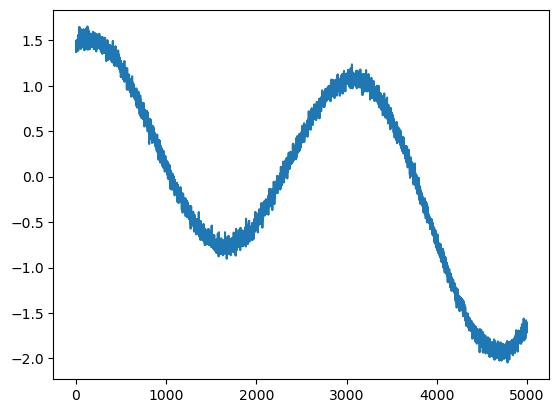

In [12]:
# Define number of data points
N = 5000

# Generate random frequencies and amplitudes for sin and cos
freq_sin = np.random.uniform(0.1, 0.5)
amp_sin = np.random.uniform(0.5, 1.5)
freq_cos = np.random.uniform(0.2, 0.8)
amp_cos = np.random.uniform(0.5, 1.5)

# Generate time series data as a 1D array
t = np.linspace(0, 20, N)
data = amp_sin * np.sin(freq_sin * t) + amp_cos * np.cos(freq_cos * t) + np.random.randn(N) * 0.05

plt.plot(data)


In [13]:
from backtrack import findmaxCH4

In [14]:
%%time
max_c_noloop, time_max_c_noloop, ijk_max_noloop = findmaxCH4(data, t)

CPU times: user 36 µs, sys: 96 µs, total: 132 µs
Wall time: 21.2 µs


#### findmaxCH4 has been tested by Bryan, seems to work as intended

# Backtrack Function Testing

In [15]:
from backtrack import backtrack

## These variables are all made up. Just looking to see what it requires and see if it runs. 

In [16]:
sensor_x = 1
sensor_y = 2

pathmax = 3.2
dt = 1

ijk_start = 2

u_sonic = u_data
v_sonic = v_data

In [17]:
np.size(ijk_start)

1

In [18]:
%%time
backtrack(ijk_start, u_sonic, v_sonic, dt, sensor_x, sensor_y, 5)

CPU times: user 63 µs, sys: 222 µs, total: 285 µs
Wall time: 35 µs


(1.608658495230622, -2.3897444331105744)

### Pathmax Function

In [19]:
from backtrack import pathmax

In [20]:
factor_x = 0.5
x_width = 11
factor_y = 0.25
y_width = (30, 2)


Next one is supposted to error

In [21]:
pathmax( x_width, y_width, factor_x, factor_y)

TypeError: All inputs must have the same shape.

In [22]:
y_width = 30

This should work:

In [23]:
paths = pathmax( x_width, y_width, factor_x, factor_y)
paths

5.5

### Data ingester for B Travis

In [24]:
data = '../test_data/training_data_SBL2m_Ug2p5_src1-8kg_b.5.nc'

In [25]:
ds = xr.load_dataset(data)

In [26]:
x = ds.encoder_input.isel(mask=0).values

I need to clean this up, and add ch4 to the output. But this is what I have so far. 

In [27]:
def create_input_data_for_bryan(x, num_met_sensors =1, num_sensors = 3):
    '''
    This function uses numpy arrays as input
    The variable should have a length of 8: ['ref_distance', 'ref_azi_sin', 'ref_azi_cos', 'ref_elv', 'u', 'v', 'w', 'q_CH4']
    '''
    print('Shape of input x', x.shape)

    n_timesteps = x.shape[2]

    factor_x = 0.4
    x_width = 40
    factor_y = 0.4
    y_width = 40

    dt = 1

    pathmax_value = pathmax( x_width, y_width, factor_x, factor_y)

    #for i in range(x.shape[0]): # this loop might be unessary
    for i in range(5): # this loop might be unessary
        print('sample numnber', i)
        ## U & V time series extracted from met sensor
        u = x[i][[0], :, 4]
        v  = x[i][[0], :, 5]
        
        # pulling met sensor location
        met_dist = x[i][[0], :, 0].T[0]
        met_azi_sin  = x[i][[0], :, 1].T[0]
        met_azi_cos  = x[i][[0], :, 2].T[0]
        x_met, y_met = polar_to_cartesian(met_dist, met_azi_sin, met_azi_cos)

        # pulling the information from the ch4 sensors, distance, azi_sin and azi_cos and ch4
        ref_dist = x[i][[1, 2, 3], :, 0].T[0]
        azi_sin  = x[i][[1, 2, 3], :, 1].T[0]
        azi_cos  = x[i][[1, 2, 3], :, 2].T[0]

        x_, y_ = polar_to_cartesian(ref_dist, azi_sin, azi_cos)
        ref_elevation  = x[i][[1, 2, 3], :, 3].T[0]
        stacked_data = np.column_stack((x_, y_, ref_elevation))

        # this is the sensor xyz data
        stacked_data.flatten()
        print('   ')
        ## emissions data
        for q in range(num_sensors):
            print('sensor number', q+1)
            ch4_data = x[i][[1, 2, 3], :, 7][q]
            
            # findmaxch4
            max_c, time_max_c, max_idx = findmaxCH4(ch4_data, np.arange(n_timesteps))
            print('max_c, max_idx, time_max_c')
            print(max_c, max_idx, time_max_c)
            backtrack_u, backtrack_v = backtrack(ijk_start=time_max_c, u_sonic=u.ravel(), v_sonic=v.ravel(), dt=dt, sensor_x=x_met[0], sensor_y=y_met[0], pathmax=pathmax_value)

    return stacked_data.flatten(), backtrack_u, backtrack_v

In [28]:
yo, yo1, yo2 = create_input_data_for_bryan(x)

Shape of input x (600, 10, 100, 8)
sample numnber 0
   
sensor number 1
max_c, max_idx, time_max_c
9.999999717180685e-10 50 50
sensor number 2
max_c, max_idx, time_max_c
0.0001767009380273521 84 84
sensor number 3
max_c, max_idx, time_max_c
9.999999717180685e-10 50 50
sample numnber 1
   
sensor number 1
max_c, max_idx, time_max_c
5.5549175158375874e-05 39 39
sensor number 2
max_c, max_idx, time_max_c
0.0004749787040054798 75 75
sensor number 3
max_c, max_idx, time_max_c
9.806657180888578e-05 98 98
sample numnber 2
   
sensor number 1
max_c, max_idx, time_max_c
9.999999717180685e-10 50 50
sensor number 2
max_c, max_idx, time_max_c
0.00010663082503015175 35 35
sensor number 3
max_c, max_idx, time_max_c
1.3212295925768558e-05 39 39
sample numnber 3
   
sensor number 1
max_c, max_idx, time_max_c
9.999999717180685e-10 50 50
sensor number 2
max_c, max_idx, time_max_c
9.999999717180685e-10 50 50
sensor number 3
max_c, max_idx, time_max_c
9.999999717180685e-10 50 50
sample numnber 4
   
senso

xyz of sensors

In [29]:
yo

array([ 4.26088862, 39.77241485,  0.        , -4.02022121, 33.82067057,
        0.        , -6.25012687, 16.76114299,  0.        ])

backtracked u

In [30]:
yo1

-0.05520490659721967

backtracked v

In [31]:
yo2

0.552415267146867